# Fake news prediction model

## Dependencies

In [157]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

## Data processing

### Loading the cleaned data

In [158]:
chunk_size = 1000
rows = 868346
chunks = []

# * Load csv file with tqdm for tracking progress
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("10,000_data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)
df = df.dropna(subset=['content', 'type'])

Loading csv file:   1%|          | 10000/868346 [00:00<00:38, 22327.00it/s]


### Distribution

In [159]:
print(f'Total article amount: {len(df['type'])}')
print(f'Fake article amount: {len(df[df['type']=='fake'])}')
print(f'Reliable article amount: {len(df[df['type']=='reliable'])}')
print(f'Reliable percentage: {(len(df[df['type']=='reliable'])/len(df['type'])*100):.2f}%')

Total article amount: 9552
Fake article amount: 3496
Reliable article amount: 5395
Reliable percentage: 56.48%


# Simple model

We will try to add the cleaned BBC dataset to our current one, and see how the model performs.

In [160]:
df2 = pd.read_csv('bbc_dataset/bbc_cleaned_fr.csv')

# Concatenate vertically (stacking rows)
merged_df = pd.concat([df, df2], ignore_index=True)

merged_df.to_csv('bbc_dataset/merged_data.csv', index=False)

### Splitting

In [161]:
X = merged_df['content']
y = merged_df['type'] 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

TypeError: '<' not supported between instances of 'int' and 'str'

In [ ]:
#X_train = pd.concat([X_train, df2], ignore_index=True)

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)
print(class_counts / len(y_train) * 100)

# Create feature extraction pipeline with n-grams
feature_extraction = Pipeline([
    ('vect', CountVectorizer(
        max_features=5000,             # Limit to top 5,000 features
    )),
    #('tfidf', TfidfTransformer()),
])

# Apply feature extraction to training data
X_train_features = feature_extraction.fit_transform(X_train)
print(f"\nFeature matrix shape: {X_train_features.shape}")

# Find the minimum number of samples in any class
min_class_count = min(class_counts)
print(f"Minimum class count: {min_class_count}")


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)

# Show class distribution after resampling
print("\nClass distribution after resampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train_resampled)*100:.2f}%)")

# Train the logistic regression model on the resampled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)

TypeError: '<' not supported between instances of 'int' and 'str'

# Advanced model

### Splitting

In [ ]:
X = df['content']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

### Vectorization

In [ ]:
vectorizer = TfidfVectorizer(max_features=100000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("Test class distribution:")
print(y_test.value_counts())

Original training class distribution:
type
reliable      1724
political     1414
fake          1106
conspiracy     974
bias           971
rumor          383
unknown        326
clickbait      207
unreliable     202
junksci        146
satire         102
hate            86
Name: count, dtype: int64
Test class distribution:
type
reliable      431
political     353
fake          277
bias          243
conspiracy    243
rumor          96
unknown        82
clickbait      52
unreliable     51
junksci        37
satire         25
hate           21
Name: count, dtype: int64


### Over sampling

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

## Training and evaluation

### Model training

In [ ]:
classifier = MLPClassifier(
    solver='adam',
    alpha=1e-4,
    hidden_layer_sizes=(50, 50, 50),
    shuffle=False,
    random_state=42,
    tol=0.0001,
    verbose=True,
    max_iter=50,
    batch_size=1024,
    learning_rate='adaptive',
    n_iter_no_change=4
)
classifier.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 0.21091826
Iteration 2, loss = 0.19983332
Iteration 3, loss = 0.15051730
Iteration 4, loss = 0.11591773
Iteration 5, loss = 0.08668380
Iteration 6, loss = 0.05976950
Iteration 7, loss = 0.04254922
Iteration 8, loss = 0.03312973
Iteration 9, loss = 0.03112516
Iteration 10, loss = 0.02768854
Iteration 11, loss = 0.02149680
Iteration 12, loss = 0.01773085
Iteration 13, loss = 0.01573440
Iteration 14, loss = 0.01491887
Iteration 15, loss = 0.01380041
Iteration 16, loss = 0.01270064
Iteration 17, loss = 0.01154453
Iteration 18, loss = 0.01219706
Iteration 19, loss = 0.00774687
Iteration 20, loss = 0.00687735
Iteration 21, loss = 0.00677121
Iteration 22, loss = 0.00636524
Iteration 23, loss = 0.00646725
Iteration 24, loss = 0.00652546
Iteration 25, loss = 0.00628777
Iteration 26, loss = 0.00581380
Iteration 27, loss = 0.00583752
Iteration 28, loss = 0.00574632
Iteration 29, loss = 0.00534364
Iteration 30, loss = 0.00486073
Iteration 31, loss = 0.00484895
Iteration 32, los

MLPClassifier(batch_size=1024, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', max_iter=50, n_iter_no_change=4,
              random_state=42, shuffle=False, verbose=True)

### Evaluation

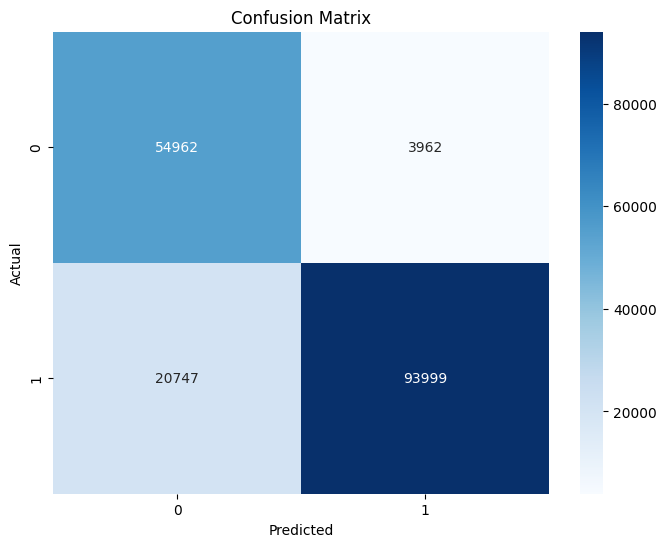

              precision    recall  f1-score   support

        fake       0.73      0.93      0.82     58924
    reliable       0.96      0.82      0.88    114746

    accuracy                           0.86    173670
   macro avg       0.84      0.88      0.85    173670
weighted avg       0.88      0.86      0.86    173670



In [ ]:
y_pred = classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))